In [84]:
import os
from datetime import datetime

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline   
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,RocCurveDisplay
)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import plotly.express as px

# Import dataset

In [85]:
df = pd.read_csv('../data/raw/conversion_data_train.csv', sep=',')

In [86]:
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [87]:
df.shape

(284580, 6)

# Peprocessing

In [88]:
target = "converted"
X = df.drop(columns=[target])
y = df[target]

categorical_features = [c for c in X.columns if X[c].dtype == "object"]
numeric_features = [c for c in X.columns if c not in categorical_features]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

numeric_preprocessor = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
])

categorical_preprocessor = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocessor, numeric_features),
        ("cat", categorical_preprocessor, categorical_features),
    ]
)

# Baseline Logistic Regression

In [89]:
logreg = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    random_state=0
)

pipe_lr = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", LogisticRegression(max_iter=2000, random_state=0))
])

pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'new_user',
                                                   'total_pages_visited']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['country', 'source'])])),
                ('model', LogisticRegression(max_iter=2000, random_state=0))])

# Evaluation du modèle

In [90]:
def evaluate_model(name, pipe, X_test, y_test):
    y_proba = pipe.predict_proba(X_test)[:, 1]
    y_pred = pipe.predict(X_test)
    metrics = {
        "model": name,
        "f1": f1_score(y_test, y_pred, zero_division=0),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_test, y_proba)
    }
    return metrics, y_pred, y_proba

In [91]:
metrics_lr, ypred_lr, yproba_lr = evaluate_model("LogReg", pipe_lr, X_test, y_test)

,model,f1,precision,recall,roc_auc
0,LogReg,0.7675,0.8653,0.6895,0.9869


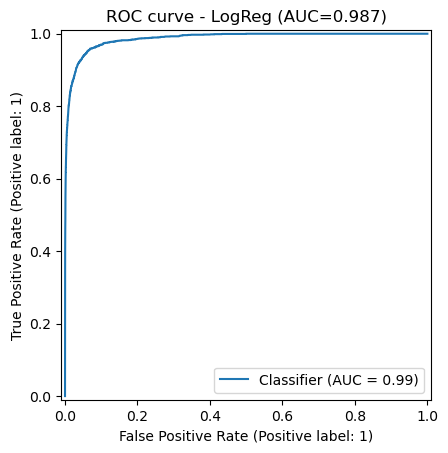

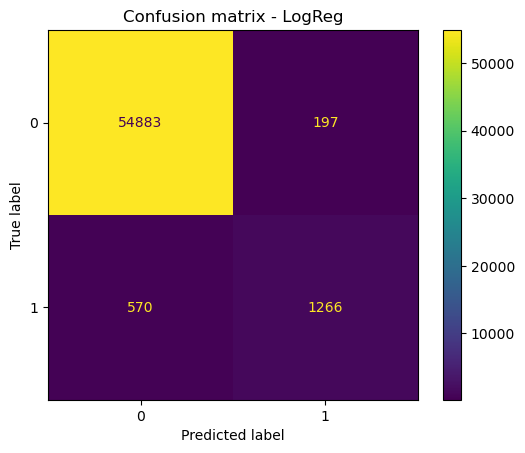

In [92]:
results_df = pd.DataFrame([metrics_lr])
display(results_df.round(4))

RocCurveDisplay.from_predictions(y_test, yproba_lr)
plt.title(f"ROC curve - {metrics_lr['model']} (AUC={metrics_lr['roc_auc']:.3f})")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, ypred_lr, values_format="d")
plt.title(f"Confusion matrix - {metrics_lr['model']}")
plt.show()

## Sauvegarde des logs

In [93]:
results_path = "../data/outputs/model_results.csv"
os.makedirs(os.path.dirname(results_path), exist_ok=True)

row = metrics_lr.copy()
row["timestamp"] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

row_df = pd.DataFrame([row])

if os.path.exists(results_path):
    row_df.to_csv(results_path, mode="a", header=False, index=False)
else:
    row_df.to_csv(results_path, mode="w", header=True, index=False)

print(f"Résultats ajoutés à {results_path}")

Résultats ajoutés à ../data/outputs/model_results.csv


# Retraining sur intégralité du dataset

In [94]:
target = "converted"
X_full = df.drop(columns=[target])
y_full = df[target].astype(int)

pipe_lr.fit(X_full, y_full)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'new_user',
                                                   'total_pages_visited']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['country', 'source'])])),
                ('model', LogisticRegression(max_iter=2000, random_state=0))])

## Chargement des données non-labellisée

In [95]:
df_unlabeled = pd.read_csv("../data/raw/conversion_data_test.csv")

feature_cols = X_full.columns.tolist()
df_unlabeled = df_unlabeled[feature_cols]

y_proba = pipe_lr.predict_proba(df_unlabeled)[:, 1]
y_pred  = pipe_lr.predict(df_unlabeled)

In [96]:
submission = pd.DataFrame({
    "id": np.arange(len(df_unlabeled)),
    "converted": y_pred
})
submission.to_csv("../data/outputs/conversion_data_test_predictions_baseline.csv", index=False)

In [101]:
dist = submission["converted"].value_counts().sort_index().reset_index()
dist.columns = ["converted", "count"]
dist["label"] = dist["converted"].map({0: "Non converti (0)", 1: "Converti (1)"})

fig = px.pie(
    dist,
    names="label",
    values="count",
    title="Distribution des prédictions",
)

fig.update_traces(textinfo="percent+value")  # % + effectif

fig.update_layout(
    width=650, height=650,                 # carré
    legend_title_text="Classe prédite",
    margin=dict(t=80, l=20, r=20, b=20),
)
fig.show()